# Predicting Building Energy Use

This tutorial demonstrates how to utilize NYC Open data on [building energy & water usage](https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/qb3v-bbre) to predict city wide building performance. It will introduce fundamental concepts of predictive modelling: feature engineering, training a model, and evaulating model performance. 

We will use variables from NYC PLUTO and [building footprints](https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh) datasets to generate features and predict a building's annual energy consumption.

The first step is to import all the necessary libraries:
- [Geopandas](https://geopandas.org/index.html): similar to pandas with extensions to make it easier to work  with geospatial data.
- [Matplotlib](https://matplotlib.org/): the defacto library for drawing/plotting in Python
- [Sodapy](https://github.com/xmunoz/sodapy): is an interface for interacting with NYC Open data (more broadly the Socrata API that NYC Open data relies on)
- [Shapely](https://shapely.readthedocs.io/en/stable/manual.html): a library for manipulaitng and analysing geometry
- [Sci-kit learn](https://scikit-learn.org/stable/): machine learning library
- [Psycopg2](https://www.psycopg.org/docs/): is a utility library that makes it easier to connect to postgresql

In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from sodapy import Socrata
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.kernel_ridge import KernelRidge

In [3]:
import warnings
warnings.filterwarnings("ignore")

<br>

### Download Building Energy Data
Next we use the Socrata library to download building energy data from the NYC open data portal.

In [6]:
client = Socrata("data.cityofnewyork.us", os.environ['nyc_soda_cuny_token'])
results = client.get("qb3v-bbre", limit=30000)
bldg_energy = pd.DataFrame.from_records(results)

<br>

### Data wrangling

This next section will focus on cleaning up some of the idiosyncrasies of the energy dataset. Specifically, renaming columns, checking data types, and removing duplicates.

The column names from the energy datasets are fairly verbose, so below we use the Pandas **rename()** function to simplify the BBL and building ID columns. BBL, short for Borough Block Lot, is an identification code for buildings across the city used by the Planning department.

In [7]:
bldg_energy.rename(columns={'bbl_10_digits': 'bbl',
                            'nyc_building_identification': 'bin'}, 
                   inplace=True)

In [8]:
print(bldg_energy.shape)
bldg_energy.head(3)

(28807, 67)


,order,property_id,property_name,parent_property_id,parent_property_name,city_building,bbl,nyc_borough_block_and_lot,bin,address_1_self_reported,...,water_use_all_water_sources,water_use_intensity_all_water,water_required,generation_date,latitude,longitude,community_board,council_district,census_tract,nta
0,1,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1009970029,1009970029,1022631,1155 Avenue of the Americas,...,Not Available,Not Available,No,2020-05-28T04:27:00.000,40.756631,-73.982826,105,4,119,Midtown-Midtown South
1,2,8139,200,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1013150001,1013150001,1037545,200 East 42nd St.,...,7310.6,19.02,Yes,2020-05-28T04:27:00.000,40.750698,-73.974306,106,4,88,Turtle Bay-East Midtown
2,3,8604,114,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1009990019,1009990019,1022667,114 West 47th st,...,Not Available,Not Available,No,2020-05-28T04:27:00.000,40.75831,-73.982504,105,4,125,Midtown-Midtown South


<br>
<br>

Missing values are called 'Not Available' within the data, below we convert all occurences of missing values to the NaN data type that is more common in Pandas/Nunmpy.

Strangely, many of the numeric columns are downloaded in text/string format, we also convert these to integers and floats.

In [9]:
bldg_energy.replace(to_replace={'Not Available': np.nan}, inplace=True)

In [10]:
bldg_energy['number_of_buildings'] = bldg_energy['number_of_buildings'].astype(int)

In [11]:
cols = ['energy_star_score', 'occupancy', 'dof_gross_floor_area_ft',
        'site_eui_kbtu_ft', 'weather_normalized_source', 'weather_normalized_site',
        'weather_normalized_site_1', 'fuel_oil_1_use_kbtu', 'fuel_oil_2_use_kbtu',
        'fuel_oil_4_use_kbtu', 'fuel_oil_5_6_use_kbtu', 'diesel_2_use_kbtu',
        'kerosene_use_kbtu', 'propane_use_kbtu', 'district_steam_use_kbtu',
        'district_hot_water_use_kbtu', 'district_chilled_water_use',
        'natural_gas_use_kbtu', 'weather_normalized_site_2',
        'electricity_use_grid_purchase', 'electricity_use_grid_purchase_1',
        'weather_normalized_site_3', 'annual_maximum_demand_kw',
        'total_ghg_emissions_metric', 'direct_ghg_emissions_metric',
        'water_use_all_water_sources', 'water_use_intensity_all_water',
        'latitude', 'longitude', 'indirect_ghg_emissions_metric']

In [12]:
for col in cols:
    bldg_energy[col] = bldg_energy[col].astype(float)

### Downloading Pluto data

Next we can download the Planning departments [building data](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Notice when the csv is loaded below we specify the data type for a few columns. This ensures identification columns are read as categorical variables rather than numeric.

In [13]:
path = 'path_to_pluto/pluto_20v6.csv'

In [14]:
df = pd.read_csv(path, low_memory=False, 
                 dtype={'block': str, 'lot': str,
                        'cd': str, 'ct2010': str,
                        'cb2010': str, 'schooldist': str,
                        'council': str, 'zipcode': str,
                        'landuse': str, 'bbl': str})
df['bbl'] = df['bbl'].str.replace('.00000000', '')

In [15]:
print(df.shape)
df.head(3)

(858308, 90)


,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,BX,5639,78,210,NaN,0002,NaN,13,NaN,NaN,...,NaN,NaN,4,1.0,1.0,20v6,NaN,40.840277,-73.780735,NaN
1,BK,8273,111,318,1018,1001,18,46,11236,L170,...,NaN,NaN,4,1.0,1.0,20v6,t,40.644117,-73.886114,NaN
2,BX,5092,18,212,436,1000,11,12,10466,E063,...,NaN,NaN,1,NaN,NaN,20v6,NaN,40.899491,-73.848780,NaN


### Loading building footprints data

The final dataset to load is the NYC building footprint data. Below we do another round of specifying data types, ensuring columns are of the correct type.

In [16]:
path = "path_to_footprints/Building Footprints.geojson"
bldgs = gpd.read_file(path, dtype={'shape_area': float, 'heightroof': float,
                                  'cnstrct_yr': int, 'groundelev': int,
                                  'shape_len': float})

In [17]:
bldgs.rename(columns={'base_bbl': 'bbl'}, inplace=True)

In [18]:
print(bldgs.shape)
bldgs.head(3)

(1113840, 15)


,name,bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry
0,None,3044520815,854.66243317866,21.60850812,3044520815,2009,Constructed,2100,18,Photogramm,3394646,2017-08-22T00:00:00+00:00,1212853,125.0797955584,"MULTIPOLYGON (((-73.87130 40.65717, -73.87136 ..."
1,None,4030640041,217.59424346169,10.36,4030640041,1930,Constructed,5110,122,Photogramm,4548330,2017-08-17T00:00:00+00:00,1226227,60.22585821856,"MULTIPOLYGON (((-73.87671 40.71425, -73.87677 ..."
2,None,4139430001,946.42747637737,29.81157033,4139430001,1960,Constructed,2100,10,Photogramm,4460479,2017-08-22T00:00:00+00:00,581946,123.14194057237,"MULTIPOLYGON (((-73.85195 40.66235, -73.85195 ..."


<br>
<br>

### Merging data

The next step is to merge the three datasets into one single DataFrame. However, there are a lot of columns that are superflous to this application – therefore, when merging we only choose 3 energy specific columns to merge: the annual greenhouse gas emmissions (metric), the electricity grid usage, and natural gas usage. These are the values we will try to predict with a model.

We merge the enegy and pluto datasets using the BBL column.

In [43]:
bcols = ['bbl', 'bin', 'total_ghg_emissions_metric', 'direct_ghg_emissions_metric', 
         'electricity_use_grid_purchase', 'natural_gas_use_kbtu', 'occupancy']
temp = bldg_energy[bcols].merge(df, on='bbl')

<br>
<br>

similarly there are many superflous columns in the Pluto dataset, so here we only include columns that we'll use in model training.

In [44]:
cols = ['easements', 'lotarea', 'bldgarea', 'landuse',
        'comarea', 'resarea', 'officearea', 'retailarea',
        'garagearea', 'strgearea', 'factryarea', 'otherarea',
        'areasource', 'numbldgs', 'numfloors', 'unitsres',
        'unitstotal', 'lotfront', 'lotdepth', 'bldgfront',
        'bldgdepth','yearbuilt', 'yearalter1', 'yearalter2',
        'borough']

In [45]:
temp = temp[cols+bcols]

In [46]:
bfcols = ['shape_area', 'heightroof', 'groundelev',
          'bin', 'shape_len', 'geometry']

In [47]:
temp = temp.merge(bldgs[bfcols], on=['bin'])

Here we remove any duplicate rows within the data

In [48]:
temp.drop_duplicates(inplace=True)

In [49]:
temp.shape

(25052, 37)

And fill missing area values with zero

In [50]:
temp.fillna({'otherarea':0,'factryarea':0,'strgearea':0,'garagearea':0,
             'retailarea':0,'officearea':0,'resarea':0,'comarea':0},
            inplace=True)

In [51]:
temp.dropna(inplace=True)

In [52]:
temp.shape

(22027, 37)

### Scope of the model

The building energy dataset includes energy consumnption metrics for various types of buildings from factories to offices, and for all boroughs across the city. This poses several challenges for predictive modelling – for instance, energy consumption patterns are obviously vastly different between offices and single family homes, and between tall glass clad skyscrapers in FiDi and 3-storey wood frame homes in Williamsburg. Although one could build a single model to capture patterns across building types and boroughs, it would be beyond the scope of this tutorial to try to model such complexity. Therefore, below we limit the scope of the model to only include office buildings within Manhattan.

In [53]:
temp = temp[(temp['landuse'].isin(['05'])) & (temp['borough'] == 'MN')]

### Feature Engineering

[Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering) is perhaps the most important aspect of machine learning and predictive modelling. It involves using expertise within a specific field to extract metrics from raw data. These metrics are then used to train an ML model. Below we create a number of features / metrics from the raw Pluto and building footprint dataset to feed our model. The raw data has polygons for raw outlines of buildings, heights of roofs, and the years buildings were built. ML models require features to be of numeric data types, so feeding the model raw polygon shapes or the year built (remember year built would be considered a categorical variable) is not ideal (for this specific case). *Note: some of the raw features within both datasets can be used directly (e.g. building area, building height, etc)*. 

The features we create from the raw data are:
- **Year Type:** this feature categorizes the years into 5 distinct time periods (pre-1930, 1930-50, 1950-70, 1930-50, post-1990). We then encode these categories into numeric form using the Sci-kit learn library
- **Standalone:** this feature is a binary value indicating whether the building is adjacent to any other structure. Here we use the Shapely Python library to do simple geometry analysis to determine whether a building is standalone or not
- **Years since:** this feature is an integer specifiying the number of years that have passed since the building was built
- **FAR:** this is the ratio between building area over building lot area
- **Volume:** as the name suggests this is building area x height
- **Residential %:**: this is the percentage of residential area in the building
- **Office %:**: this is the percentage of office area in the building
- **Retail %:**: this is the percentage of retail area in the building
- **Factory %:**: this is the percentage of factory area in the building

In [54]:
temp['shape_area'] = temp['shape_area'].astype(float)
temp['heightroof'] = temp['heightroof'].astype(float)
temp['shape_len'] = temp['shape_len'].astype(float)
temp['groundelev'] = temp['groundelev'].astype(float)

In [55]:
temp['volume'] = temp['shape_area'] * temp['heightroof']
temp['surface_area'] = temp['shape_len'] * temp['heightroof']
temp['far'] = temp['bldgarea'] / temp['lotarea']
temp['respct'] = temp['resarea'] / temp['bldgarea']
temp['offpct'] = temp['officearea'] / temp['bldgarea']
temp['retpct'] = temp['retailarea'] / temp['bldgarea']
temp['facpct'] = temp['factryarea'] / temp['bldgarea']
temp['strpct'] = temp['strgearea'] / temp['bldgarea']

In [56]:
temp['yeartype'] = None
temp['yeartype'].loc[temp['yearbuilt'] < 1930] = 'pre-1930'
temp['yeartype'].loc[(temp['yearbuilt'] >= 1930) & (temp['yearbuilt'] < 1950)] = '1930-50'
temp['yeartype'].loc[(temp['yearbuilt'] >= 1950) & (temp['yearbuilt'] < 1970)] = '1950-70'
temp['yeartype'].loc[(temp['yearbuilt'] >= 1970) & (temp['yearbuilt'] < 1990)] = '1930-50'
temp['yeartype'].loc[(temp['yearbuilt'] >= 1990)] = 'post-1990'

In [57]:
temp['years_since'] = 2020 - temp['yearbuilt']

In [58]:
temp['refurb1'] = temp['yearalter1'].astype(bool).astype(int)
temp['refurb2'] = temp['yearalter2'].astype(bool).astype(int)

In [59]:
le = preprocessing.LabelEncoder()

In [60]:
temp['yrtype'] = le.fit_transform(temp['yeartype'])

In [38]:
def standalone_check(x):
    temp = bldgs.loc[bldgs['geometry'].touches(x)]
    check = temp.shape[0] == 0
    return check

In [39]:
temp['standalone'] = temp['geometry'].apply(lambda x: standalone_check(x))

In [61]:
temp.drop_duplicates(subset='bin', inplace=True)

In [62]:
temp.dropna(inplace=True)

In [63]:
temp.shape

(1574, 50)

### Feature Selection

[Feature Selection](https://en.wikipedia.org/wiki/Feature_selection) is another important step in machine learning and involves choosing relevant features to feed an ML model. Why do feature selection, why not feed as many features into a model as possible? There are a number of reasons not to do this, and researchers have devoted careers to answering the question. One major reason is the possiblity of models [overfitting](https://en.wikipedia.org/wiki/Overfitting) when large amounts of features are fed into them. A simple rule of thumb is that one should not feed more features than there are rows of data. For our example there around 1500 rows of data, so the number of features should be much less than this number. Another reason, to do feature selection is to simplify the modelling process and make results easier to interpret.

In the below section we look at the linear correlation between building features and energy consumption in order to rank features according to their correlation coefficient. We will then use that to prioritize what features to feed the model.

In [64]:
corrs = temp.drop(['bbl', 'bin', 'yeartype', 'geometry'], axis=1).apply(lambda x: pearsonr(x, temp['total_ghg_emissions_metric']))
corrs = corrs.reset_index()
corrs[['r', 'p']] = pd.DataFrame(corrs[0].tolist(), 
                                 index=corrs.index)
corrs.drop([0], axis=1, inplace=True)

In [65]:
corrs.loc[corrs['p'] < .01].sort_values(by='r', ascending=False)[2:10]

,index,r,p
2,bldgarea,0.872568,0.000000e+00
34,volume,0.829964,0.000000e+00
4,comarea,0.817968,0.000000e+00
35,surface_area,0.812956,0.000000e+00
6,officearea,0.777516,5.535017e-319
30,shape_area,0.719602,2.777854e-251
33,shape_len,0.672157,1.928626e-207
1,lotarea,0.661680,7.658654e-199


<br> 
<br>

The above list shows all features that have a significant (p < 0.01) linear correlation to green house gas emissions. From the above we can see that building area and volume have the highest linear correlation to green house gas emissions (from the features we have at hand). Not seen in the above list is the small, but significant, negative correlation between emissions and year built. In all, there are approximately 30 significantly correlated features. We can test varying configurations of these features to feed our model below.

In [66]:
temp1 = temp.drop(['electricity_use_grid_purchase', 
                   'natural_gas_use_kbtu', 
                   'direct_ghg_emissions_metric'], axis=1)

In [67]:
temp1.drop_duplicates(subset='bin', inplace=True)

In [68]:
temp1.index = temp1['bin']

### Model training

The next step now that we have an idea of what features may be the most relevant will be to train the model. For this demonstration we will use a fairly "simple" algorithm to build our regression model called, Lasso. [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)) is a well loved algorithm as it does regularization out of the box – meaning it prevents overfitting from features by penalizing model coefficients. Choosing parameters of machine learning models can be a fairly tricky process involving a lot of trial and error. We use Scikit Learns **GrisearchCV** function to find the best model parameters automatically.

The variable "current_cols" is simply the top N correlates to green house gas emissions. We select the top two to initially train the model (you might experiment with other configurations).

In [71]:
target = 'total_ghg_emissions_metric'
current_cols = corrs.reindex(corrs.r.abs().sort_values(ascending=False).index)[2:4].values[:,0].tolist()
sig_df = temp1[current_cols + [target]]

X = sig_df.drop([target], axis=1)
y = sig_df[target]
hyper_params = {'tol': np.linspace(1e-4, 0.1, 4), 
                'alpha': np.linspace(0.5,2.0, 4)}

reg = GridSearchCV(Lasso(), hyper_params)

### Model evaluation

Evaluation is the final but also one of the most important parts of predictive modelling. It involves quantifying the quality of a predictive model to ensure the model is accurate and generalizable. To do this researchers usually split data into training, test, and validation sets, where a model is trained with one portion of the data, and tested with another portion of data that it has not seen, known as the test and or validation set. This ensures the model will perform well on new data that it has not seen in the future. There are a number of additional techniques for evaluation: scoring model predictions by looking at the differences between predicted and actual values (in the test set), plotting learning and validation curves, and [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). Many of these techniques are too vast to go over in this tutorial.

Below we use SKlearns built in cross validation functionality, **KFold()**, to split our data into training and test sets to evaluate the model iteratively. We also use a number of scoring metrics to quanity the model quality, specifcally the root mean squared error (the differences between actual and predicted value) and R-squared (a measure of how much variation in emissions our model explains).

In [73]:
predictions = []
true = []
kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reg.fit(X_train, y_train)
        preds = reg.predict(X_test)
        predictions.append(preds)
        true.append(y_test)
predictions = np.array([item for sublist in predictions for item in sublist])
true = np.array([item for sublist in true for item in sublist])
res = {'rmse': mean_squared_error(true, predictions, squared=False),
       'R-squared': r2_score(true, predictions),
       'avg abs difference': np.mean(abs(predictions - true)),
       'best_params': reg.best_params_,
       'cols': current_cols}
res

{'rmse': 1492.7929371836858,
 'R-squared': 0.7545791727794043,
 'avg abs difference': 496.5872308110585,
 'best_params': {'alpha': 2.0, 'tol': 0.1},
 'cols': ['bldgarea', 'volume']}

<br>
<br>

The above metrics suggest a reasonable model – it explains 75% of the variation in green house gas emissions and is typically off by 1500 metric tons. Below we attempt to improve the quality of the model by analyzing patterns in the model errors. More specifically we are interested in knowing more about where the model tends to do well and where it does not.

<br>
<br>


### Error analysis (optional)

This final section analyzes the differences between the models predicted values to the actual emission values. This is known as error analysis and is an important part of regression. There are a number of assumptions that power regression modelling ([more here](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem)), one being that erros are uncorrelated and have equal variance. 

Below we plot the model errors against building area, if our model process is correct we would expect no clear patterns in the errors (equal variance).

In [552]:
errors = temp1[temp1['total_ghg_emissions_metric'].isin(true)]
errors['err'] = predictions - true
errors['pred'] = predictions
errors['tru'] = true
errors['pred_trans'] = np.power(predictions, 2)

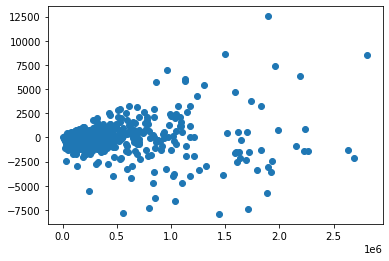

In [553]:
plt.scatter(errors['bldgarea'], errors['err'])

<br>
<br>

The above plot shows clear patterns in the errors – the errors increase as the building size increases. This is known in statistics as [Heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity), where model errors increase with the size of the fitted variables, and is a common issue in regression modelling. There are a number of reasons why heteroscedasticity occurs: outliers in the data, nonlinearity in the target variable, skewed data, etc. To overcome it a researcher could explore any number of the aformentioned topics, which would be beyond the scope of this tutorial.

Below we run the model training again, this time removing outliers and weighting the training data to mitigate the heteroscedasticity.

In [79]:
current_cols = corrs.reindex(corrs.r.abs().sort_values(ascending=False).index)[2:4].values[:,0].tolist()
sig_df = temp1[current_cols + [target]]
sig_df = sig_df[sig_df[target]<2.2e4]

X = sig_df.drop([target], axis=1)
y = sig_df[target]
hyper_params = {'tol': np.linspace(1e-4, 0.2, 7), 
                'alpha': np.linspace(0.1,2.0, 10)}

reg = GridSearchCV(Lasso(), hyper_params)

predictions = []
true = []
kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reg.fit(X_train, y_train, sample_weight=(1/X_train['bldgarea']))
        preds = reg.predict(X_test)
        predictions.append(preds)
        true.append(y_test)
predictions = np.array([item for sublist in predictions for item in sublist])
true = np.array([item for sublist in true for item in sublist])
res = {'rmse': mean_squared_error(true, predictions, squared=False),
       'R-squared': r2_score(true, predictions),
       'avg abs difference': np.mean(abs(predictions - true)),
       'best_params': reg.best_params_,
       'cols': current_cols}
res

{'rmse': 1062.9758002994474,
 'R-squared': 0.8406577116287324,
 'avg abs difference': 461.96919836640114,
 'best_params': {'alpha': 2.0, 'tol': 0.13336666666666666},
 'cols': ['bldgarea', 'volume']}

<br>

### Final Results

We can see that removing the outliers (2 data points), adjusting the hyperparameters, and adding sample weights improved the model significantly. We see a ~30% increase in accuracy, and an improvement in the amount of variation the model explains. Considering this model is trained with only two variables, it appears to be a reasonable predictor of building emissions. We could potentially increase the model accuracy with additional features like building facade material or information about the building's systems.